<h1 style="background-color:powderblue; text-align: center; font-family:verdana; font-size:250%;">
    Ford GoBike tripdata Exploration
</h1>
<h3 style="background-color:SeaShell;text-align: center;font-family:courier; font-size:200%;">
    Notebook by: <em>Ahmed Esmat</em>
</h3>

## Investigation Overview

> The Investigation aims to get some insights about bike sharing trips details through exploring the main trips data features, getting a clear relationships of features and therefore communicate a useful notes or information about the data.


## Background

> The data set includes information about individual rides made in a bike-sharing system covering the greater San Francisco Bay area by Ford GoBike.<br>
> Ford GoBike is the Bay Area's bike share system. Bay Area Bike Share was introduced in 2013 as a pilot program for the region, with 700 bikes and 70 stations across San Francisco and San Jose ... [continue reading](https://www.crunchbase.com/organization/gobike)

## Dataset Overview

<img src="https://www.sanjoseinside.com/wp-content/uploads/2017/08/IMG_20170803_115233-772x350.jpg" width="400" style="float:center">

> It is a 1-month data of trips with more than 180000 record. The data was messy, have inapproperiate feeatures data types and missing values, specifically in members gender, birth year and station names.<br>

## Data Wrangling

> - The features data types were corrected. Then, a trial to recover station names using available staion coordinates, but in vain. These data was dropped.<br>
> - Missing member gender and birth year date was dropped and Some outliers were handled based on condition.<br>
> - Some Features were add such as distance between start and end stations (using stations' coordinates), trip speed, member Age and the day of the month.

> Are you ready for a trip to get some insights from this dataset?

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import math
from datetime import datetime

%matplotlib inline

In [2]:
#Load in the dataset and show the first rows.
ford_bike = pd.read_csv('fordgobike-tripdata.csv')

In [3]:
# Convert start_time & end_time from string to datetime format.
ford_bike[['start_time', 'end_time']] = ford_bike[['start_time', 'end_time']].apply(pd.to_datetime)

In [4]:
# Convert bike ID, start & end stations id to string.
ford_bike[['start_station_id', 'end_station_id','bike_id']] = ford_bike[['start_station_id', 'end_station_id','bike_id']].astype('object')

In [5]:
# Dropping the missed stations ID and names.
ford_bike.dropna(subset=['start_station_id'], inplace=True)

In [6]:
# Dropping the members' gender and year of birth.
ford_bike.dropna(subset=['member_gender'], inplace=True)

In [7]:
# vectorized haversine function
def haversine(lat1, lon1, lat2, lon2, to_radians=True, earth_radius=6371):
    """
    Reference:" 'https://stackoverflow.com/questions/40452759/pandas-latitude-longitude-to-distance-between-successive-rows'

    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees or in radians)

    All (lat, lon) coordinates must have numeric dtypes and be of equal length.

    """
    if to_radians:
        lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])

    a = np.sin((lat2-lat1)/2.0)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2

    return earth_radius * 2 * np.arcsin(np.sqrt(a))

In [8]:
# convert the trip start / end coordinates into distance
ford_bike['dist'] = haversine(ford_bike['start_station_latitude'],ford_bike['start_station_longitude'],ford_bike['end_station_latitude'],ford_bike['end_station_longitude'])

In [9]:
# calculate trip speed (Km/hr)
ford_bike['trip_speed'] = ford_bike['dist'] *60 *60 / ford_bike['duration_sec']

In [10]:
# Calculating the member age in years.
now = pd.Timestamp('now').year
ford_bike['age'] = now - ford_bike['member_birth_year']

<h3 style="background-color:Khaki; text-align:center; font-family:verdana; font-size:175%; line-height: 1.3">
    Distribution of FORD bikes riders' gender, type and age
</h3>

> More Than 90% of our FORD bikes riders are using subscribtion services, Males are the main gender with ~75% while ~2% of bike riders prefer not to tell about gender. It is clearly showen in the age distribution that the minimun age of travellers are 20 years, This may support a regulation set for bike riders or a data cut setting 20 years old as a threshold, while the majority of riders' age varies between 27 ~ 37 years old.

In [11]:
base_color = sb.color_palette()[9]

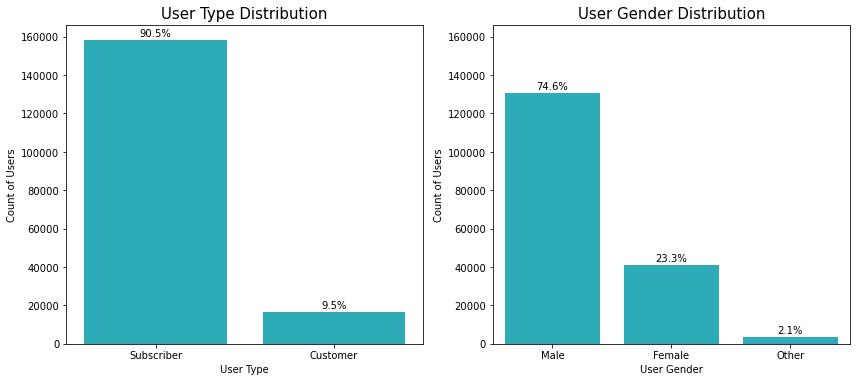

In [12]:
# Ploting the distribution of member gender & type
# Resize figure to accommodate Three plots
plt.figure(figsize = [12, 10],tight_layout=True)

# PLOT ON LEFT - SIMPLE count plot for user type
plt.subplot(2, 2, 1)
user_order = ford_bike['user_type'].value_counts()     # get the order of more frequent user type
ax1=sb.countplot(data=ford_bike,x='user_type',color=base_color, order=user_order.index);   # Plot user types
plt.title('User Type Distribution', fontsize=15);
plt.xlabel('User Type');
plt.ylabel('Count of Users');
locs_u, labels_u = plt.xticks()    # get the current tick locations and labels
for loc_u, label_u in zip(locs_u, labels_u):     # loop through each pair of locations and labels
    count_u = user_order[label_u.get_text()]     # get the text property for the label to get the correct count
    pct_string = '{:0.1f}%'.format(100*count_u/user_order.sum())
    plt.text(loc_u, count_u+2000, pct_string, ha = 'center', color = 'black')     # print the annotation just above the top of the bar

# PLOT ON middle - SIMPLE count plot for member gender
plt.subplot(2, 2, 2)
gender_order = ford_bike['member_gender'].value_counts()     # get the order of more frequent members gender
sb.countplot(data=ford_bike,x='member_gender',color=base_color, order=gender_order.index);   # Plot member gender
plt.title('User Gender Distribution', fontsize=15);
plt.xlabel('User Gender');
plt.ylabel('Count of Users');
plt.ylim(ax1.get_ylim())
locs_g, labels_g = plt.xticks()    # get the current tick locations and labels
for loc_g, label_g in zip(locs_g, labels_g):     # loop through each pair of locations and labels
    count_g = gender_order[label_g.get_text()]     # get the text property for the label to get the correct count
    pct_string = '{:0.1f}%'.format(100*count_g/gender_order.sum())
    plt.text(loc_g, count_g+2000, pct_string, ha = 'center', color = 'black')     # print the annotation just above the top of the bar

In [13]:
# Dropping member age of 80 years old and more, this may reflect wrong data entry or system bugs.
ford_bike = ford_bike.drop(ford_bike[ford_bike.age >= 80].index)

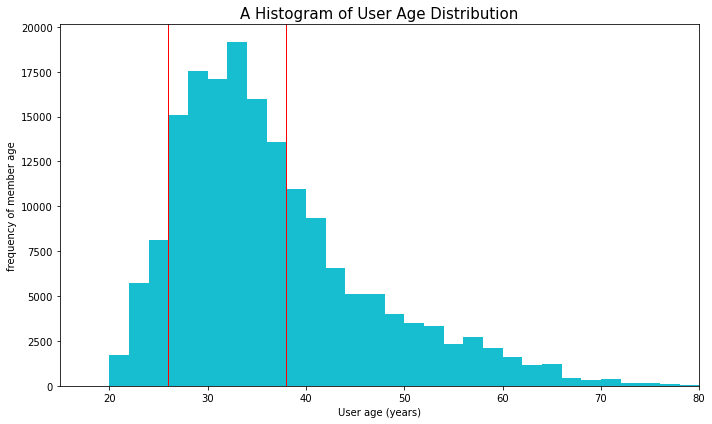

In [14]:
# PLOT the histogram for member age
plt.figure(figsize = [10, 6],tight_layout=True)                       # Resize figure to accommodate Three plots
bins_age = np.arange(0, ford_bike['age'].max()+2, 2)                  # Get the bins between [0-max age], at an interval of Two year.
plt.hist(data=ford_bike, x='age', bins=bins_age, color=base_color);   # Plot the histogram for the member age
plt.xlim([15,80]);
plt.axvline(x=26, color='r',linewidth=1);                             # Draw a red line for a selected range.
plt.axvline(x=38, color='r',linewidth=1);                             # Draw a red line for a selected range.
plt.title('A Histogram of User Age Distribution',fontsize=15);
plt.xlabel('User age (years)');
plt.ylabel('frequency of member age');

<h3 style="background-color:MistyRose; text-align:center; font-family:verdana; font-size:175%; line-height: 1.3">
    Distribution of Trips' Duration, Distance and Speed
</h3>

> Plotted on a logarithmic scale, The majority of trips lasts for (250 ~ 1000 secs), while the majority of trips moves in a distance between (0.8 ~ 2.5 Km). Calculated trips speed varies between (8 ~ 14 Km/hr).

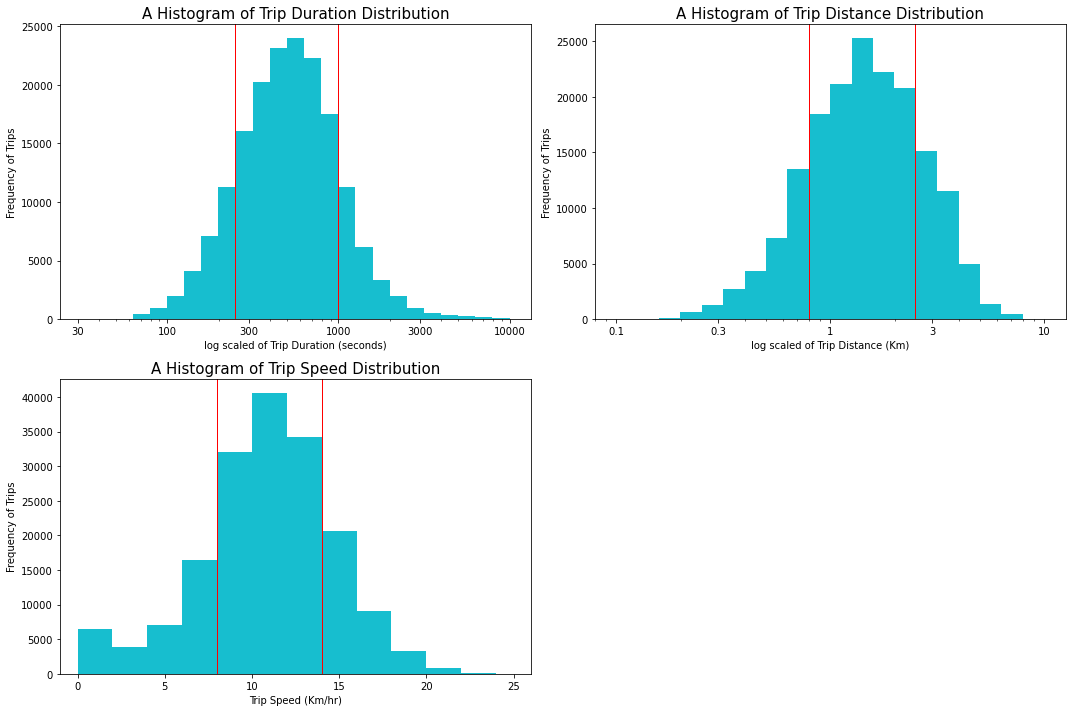

In [15]:
# Ploting the distribution of trip duration, distance and speed
# Resize figure to accommodate Three plots
plt.figure(figsize = [15, 10],tight_layout=True)

# PLOT ON LEFT - SIMPLE Histogram for trip duration
plt.subplot(2, 2, 1)
bins_dur =10 ** np.arange(1.5,4+0.1,0.1)                                         #Get the bins preparations for log scale.
ticks = [30, 100, 300, 1000, 3000, 10000]                   # Generate the x-ticks you want to apply
labels = ['{}'.format(v) for v in ticks]                                       # Convert ticks into string values, to be displayed along the x-axis
plt.xscale('log');
plt.xticks(ticks, labels);
plt.hist(data=ford_bike, x='duration_sec', bins=bins_dur, color=base_color);   # Plot the histogram for the member age
plt.axvline(x=250, color='r',linewidth=1);                                     # Draw a red line for a selected range.
plt.axvline(x=1000, color='r',linewidth=1);
plt.title('A Histogram of Trip Duration Distribution',fontsize=15);
plt.xlabel('log scaled of Trip Duration (seconds)');
plt.ylabel('Frequency of Trips');

# PLOT ON middle - SIMPLE Histogram for Trip distance
plt.subplot(2, 2, 2)
bins_dis =10 ** np.arange(-1,1+0.1,0.1)                                        # Get the bins preparations for log scale.
ticks = [0.1, 0.3, 1, 3, 10]                                                   # Generate the x-ticks you want to apply
labels = ['{}'.format(v) for v in ticks]                                       # Convert ticks into string values, to be displayed along the x-axis
plt.xscale('log'); 
plt.xticks(ticks, labels);
plt.hist(data=ford_bike, x='dist', bins=bins_dis, color=base_color);           # Plot the histogram for the member age
plt.axvline(x=0.8, color='r',linewidth=1);                                     # Draw a red line for a selected range.
plt.axvline(x=2.5, color='r',linewidth=1);                                     # Draw a red line for a selected range.
plt.title('A Histogram of Trip Distance Distribution',fontsize=15);
plt.xlabel('log scaled of Trip Distance (Km)');
plt.ylabel('Frequency of Trips');

# PLOT ON right - SIMPLE histogram for Trip Speed
plt.subplot(2, 2, 3)
bins_spd = np.arange(0, ford_bike['trip_speed'].max()+2, 2)                   # Get the bins between [0-max age], at an interval of 2 Km/hr.
plt.hist(data=ford_bike, x='trip_speed', bins=bins_spd, color=base_color);    # Plot the histogram for the member age
plt.axvline(x=8, color='r',linewidth=1);                                      # Draw a red line for a selected range.
plt.axvline(x=14, color='r',linewidth=1);                                     # Draw a red line for a selected range.
plt.xlim([-1,26])
plt.title('A Histogram of Trip Speed Distribution',fontsize=15);
plt.xlabel('Trip Speed (Km/hr)');
plt.ylabel('Frequency of Trips');

<h3 style="background-color:Turquoise; text-align:center; font-family:verdana; font-size:175%; line-height: 1.3">
    Distribution of Member Age vs Gender and User Type
</h3>

> Using Violin plots, Females mean age is slightly low in compare with Males and other. While, unknown/other gender showing a peak at ages between 50 and 60 years. Customers and Subscribers almost showing the same age distributions.

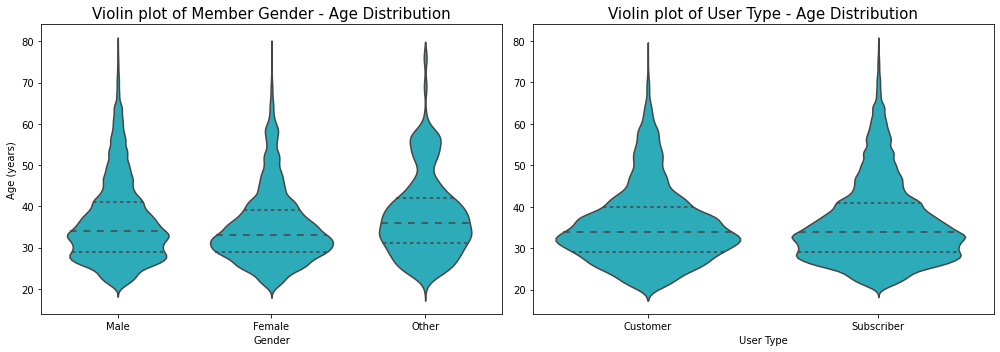

In [16]:
# Ploting the age distribution of gender and user type
# Resize figure to accommodate Two plots
plt.figure(figsize = [14, 5],tight_layout=True)

# PLOT ON LEFT - violin plot for gender - age distribution
plt.subplot(1, 2, 1)
sb.violinplot(data=ford_bike, x='member_gender', y='age', color = base_color, inner = 'quartile', order=['Male','Female','Other']); # Plot a violin for the member age & gender
plt.title('Violin plot of Member Gender - Age Distribution', fontsize=15);
plt.xlabel('Gender');
plt.ylabel('Age (years)');

# PLOT ON Right - violin plot for customer type - age distribution
plt.subplot(1, 2, 2)
sb.violinplot(data=ford_bike, x='user_type', y='age', color = base_color, inner = 'quartile'); # Plot a violin for the member age & gender
plt.title('Violin plot of User Type - Age Distribution', fontsize=15);
plt.xlabel('User Type');
plt.ylabel('');

<h3 style="background-color:Thistle; text-align:center; font-family:verdana; font-size:175%; line-height: 1.3">
    The most frequent days of the month with respect to user type
</h3>

> Using Violin and Box plots, Subscribers are distributed equally overall the month with some peaks on weekly basis, the pattern suggest normal weekend trips. For Customers, the pattern showing a service higher request rate at the second half of the month. It may reflect a non-routine work or bi-weekly work basis pattern.

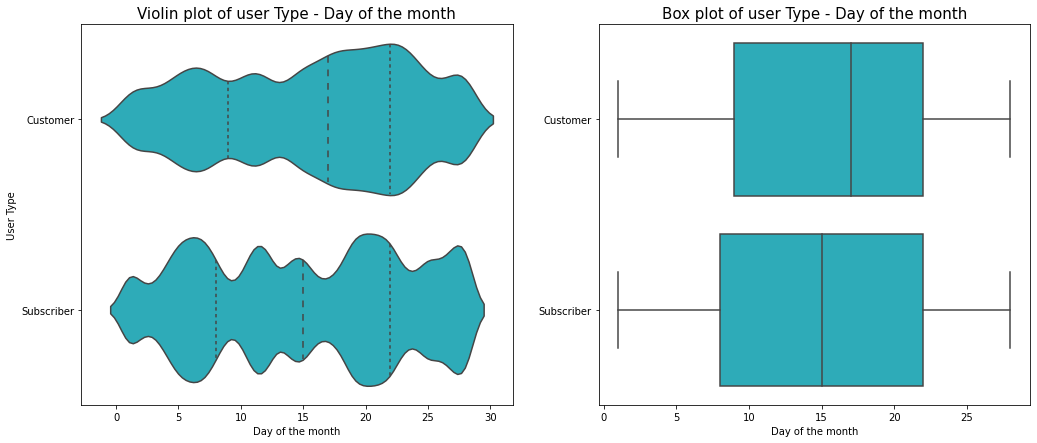

In [17]:
# Ploting the distribution of user type and day of the month
# Resize figure to accommodate Two plots
plt.figure(figsize = [17, 7])
ford_bike['start_day'] = ford_bike['start_time'].dt.day

# PLOT on left - Violin Plot for day of the month and user type
plt.subplot(1, 2, 1)
sb.violinplot(data=ford_bike, y='user_type', x='start_day', color = base_color, inner = 'quartile'); # Plot a violin for the user type & day of the month
plt.title('Violin plot of user Type - Day of the month', fontsize=15);
plt.ylabel('User Type');
plt.xlabel('Day of the month');

# PLOT on right - Box Plot for Day of month and user type
plt.subplot(1, 2, 2)
sb.boxplot(data=ford_bike, y='user_type', x='start_day', color = base_color)                        # Box Plot for the user type & day of the month
plt.title('Box plot of user Type - Day of the month', fontsize=15);
plt.ylabel('')
plt.xlabel('Day of the month');

<h3 style="background-color:Gold; text-align:center; font-family:verdana; font-size:175%;  line-height: 1.3">
    the relation between trip distance and trip duration with corresponding member gender and User type
</h3>

> A linear positive relationships with a logarithmic scale plotting, for the trip distance and trip duration for both member gender and user type. While exculding the outliers at higher trip duration, the customer/undefined gender relationship is quiet strong in positive direction.

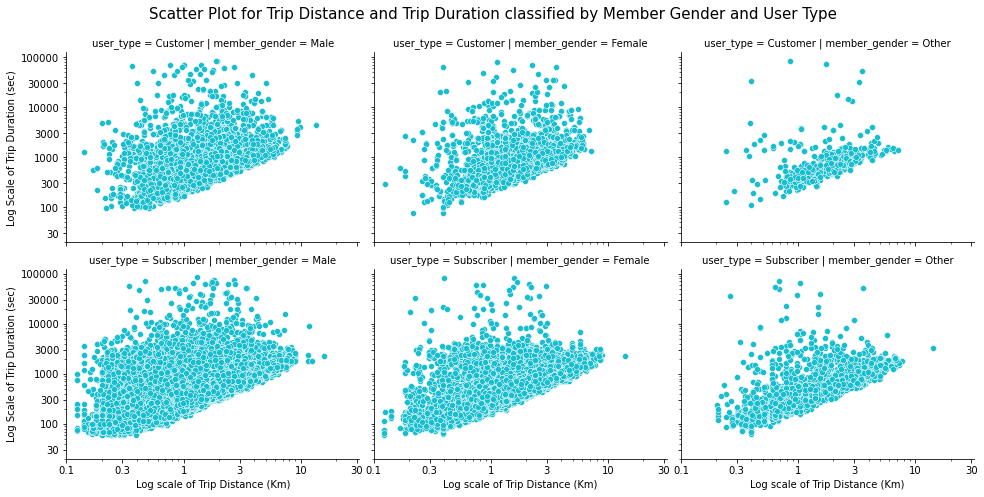

In [18]:
# Ploting the distribution of member gender and user type versus trip distance and trip duration

g = sb.FacetGrid(data = ford_bike, col = 'member_gender', col_order=['Male','Female','Other'], row = 'user_type', 
                 height=3.5, aspect=1.3)
g.map(sb.scatterplot, 'dist', 'duration_sec', color=base_color);
g.set_axis_labels('Log scale of Trip Distance (Km)', 'Log Scale of Trip Duration (sec)');
g.fig.subplots_adjust(top=0.89)                                                                                    # adjust the Figure position within facetGrid.
g.fig.suptitle('Scatter Plot for Trip Distance and Trip Duration classified by Member Gender and User Type', fontsize=15);     # Set a common Subtitle.
plt.xscale('log');
plt.yscale('log');
xtick_lock = [0.1, 0.3, 1, 3, 10, 30]
ytick_lock = [30, 100, 300, 1000, 3000, 10000, 30000, 100000]
plt.xticks(xtick_lock,xtick_lock);
plt.yticks(ytick_lock,ytick_lock);
plt.xlim(10**-1, 10** 1.5);
plt.ylim(10**1.3, 10** 5.1);

<h3 style="background-color:Chartreuse; text-align:center; font-family:verdana; font-size:175%; line-height: 1.3">
    the relation between day of the month and average trip speed vs both member gender and user type
</h3>

> Generally, overall the month, The subscribers' average trip speed is higher than customers. Also, The average travelling speed by Males is higher than Females.

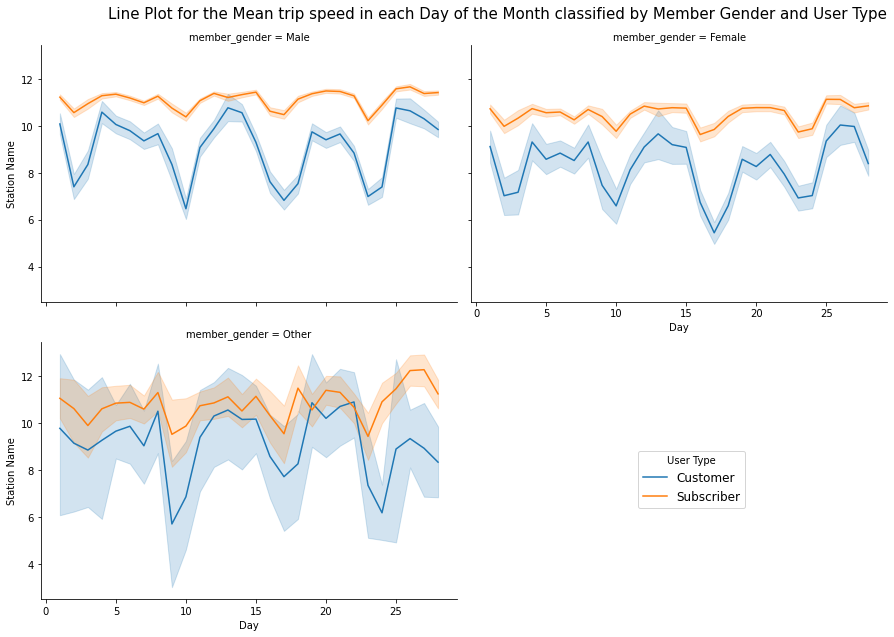

In [19]:
# Ploting the distribution of day of the month and average trip speed versus both member gender and user type

g = sb.FacetGrid(data = ford_bike, col = 'member_gender', col_order=['Male','Female','Other'], hue = 'user_type', 
                 height=4.5, aspect=1.4, col_wrap=2, subplot_kws={'xlabel':'Trip Distance (Km)','ylabel':'Trip Duration (sec)'})   # Construct FacetGrid
g.map(sb.lineplot, 'start_day', 'trip_speed');                                                                                   # Line Plotting
g.set_axis_labels('Day', 'Station Name');
g.fig.subplots_adjust(top=0.92)                                                                                                  # adjust the Figure position within facetGrid.
g.fig.suptitle('Line Plot for the Mean trip speed in each Day of the Month classified by Member Gender and User Type', fontsize=15);                        # Set a common Subtitle.
g.add_legend(title='User Type', bbox_to_anchor=(0.75,0.25), frameon= True, fontsize=12);

<h3 style="background-color:SeaShell;text-align: center;font-family:courier; font-size:300%;">
    Thank You :)
</h3>

In [20]:
!jupyter nbconvert slide_deck_tripdata.ipynb --to slides --post serve --no-input --no-prompt

^C
